# FrozenLake 8x8 - QTable

**(This doesn't work yet)**

This environment has 256 states. Because of this E-Greedy Agent takes a lot of episoded to learn the correct policy.
To speed it up in this notebook we use UCB Agent. Based on Upper-Confidence-Bound Action Selection.
For more information check [Sutton book](http://incompleteideas.net/sutton/book/bookdraft2016sep.pdf).

For this tutorial we will use [Frozen Lake 8x8](https://gym.openai.com/envs/FrozenLake8x8-v0).

FrozenLake is solved if moving average over window size 100 is >= 0.99

In [5]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import wrappers

logging.getLogger('gym').setLevel(logging.WARNING)

## Helper functions

In [6]:
def moving_average(xs, n=100):
    ret = np.cumsum(xs, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def find_index(xs, v):
    """Find index of the first value equal or greater then v"""
    for i in range(len(xs)):
        if xs[i] >= v:
            return i
    return -1

## UCB Table Agent

The UCB tries to estimate the value function and variance for each action. 
Then action is selected based on both value and variance.

The formula to select action:

$$ A_t = argmax_{a} \left[ Q_t(a) + c \sqrt{ \frac{log(t)}{N_t(a)} } \right] $$

Where:
  * $\sqrt{ \frac{log(t)}{N_t(a)} }$ - Is variance (uncertainty) of action value
  * $N_t(a)$ - How many times this action was selected
  * c - controls the degree of exploration
  
The formula to learn:

$$ Q'_{a} = \frac{Q_{a}*(n-1) + r}{n} $$

In [7]:
class QTableAgent:
    
    def __init__(self, num_states, num_actions, gamma, learning_rate):
        self.qtable = np.zeros([num_states, num_actions])
        self.num_actions = num_actions
        self.greedy_threshold = 0.9
        self.gamma = gamma
        self.alpha = learning_rate
    
    
    def choose_action(self, state, step):
        """ Choose best action (exploit) with the probability **greedy_threshold**
            Otherwise choose random action.
            The threshold is bigger for later episodes
        """
        if np.random.rand() < self.greedy_threshold * (step/1000.):
            return np.argmax(self.qtable[state,:])
        else:
            return np.random.choice(range(self.num_actions))
    
    
    def learn(self, state, action, reward, next_state):
        """Update state using Bellman equation"""
        r2 = reward + self.gamma * np.max(self.qtable[next_state,:])
        self.qtable[state, action] += self.alpha * (r2-self.qtable[state, action])

## Train agent

Messing with the rewards:

  * If we don't change reward then the probability of randomly finding solution is very low. 
    And the QTable learning will be very slow. And since there are 256 states, the propagation of
    value is very slow
  * By modifying reward we can try to at least try to not fall into the hole

Max score: 0.440000


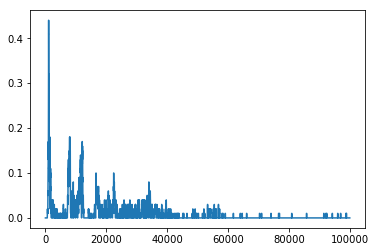

In [16]:
# Learning parameters
learning_rate = 0.8
gamma = 0.95
num_episodes = int(1e5)
solved_score = 0.99

# Environment
env = gym.make('FrozenLake8x8-v0')
# env = wrappers.Monitor(env, '../../../logs/qtable', force=True)

# Agent
agent = QTableAgent(env.observation_space.n, env.action_space.n, gamma, learning_rate)

# Learn Q-Table
rewards = []
for episode in range(num_episodes):
    s = env.reset()
    total_reward = 0
    for j in range(1000):
        a = agent.choose_action(s, episode)
        s2, reward, done, _ = env.step(a)        
        if done:
            if reward < 1:
                agent_reward = -100
            else:
                agent_reward = 100
        else:
            agent_reward = reward
        agent.learn(s, a, agent_reward, s2)
        s = s2
        total_reward += reward
        if done:
            break
    rewards.append(total_reward)
    
env.close()    

# Show summary
averaged_rewards = moving_average(rewards)    
idx = find_index(averaged_rewards, solved_score)
print('Max score: %f' % np.max(averaged_rewards))
if idx >= 0:
    print('Solved after {} episodes'.format(idx+1))

plt.plot(averaged_rewards)
plt.show()